## 全体の流れ
<ol>
<li>ライブラリの読み込み</li>
<li>データの整形</li>
<li>類似度行列の作成</li>
<li>クラスタリング</li>
<li>データ取得期間</li>
    ＊前４年間
<li>計測期間</li>
＊20日
<li>基準化</li>
    ＊最も低いところ
    ＊最初
    ＊全てやればいい

<li>予測手法</li>  
    ＊月次リターンが前月リターンより上昇下落 
    ＊平均の騰落率の上昇下落
</ol>

## ライブラリの読み込み

In [1]:
import pandas as pd
#from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import warnings
import yfinance as yf
import datetime
#from dtw import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
warnings.simplefilter("ignore")
%matplotlib inline

## データ整形（変数：データ収集期間、計測期間、基準化）

In [25]:
#2012年のdata取得
start="2012-01-01"
end="2020-12-31"
# 期間を指定して株情報を取得する
df = yf.download(tickers="^TOPX",start=start,end=end,auto_adjust=True, period='1mo', interval='1d')
df=df.reset_index()
#plt.legend()
#plt.title("TOPIX:2012-2020")
#plt.plot(data["Close"])


[*********************100%***********************]  1 of 1 completed


In [26]:
#訓練データ
df_train=df[:953]
#検証データ
df_test=df[953:]

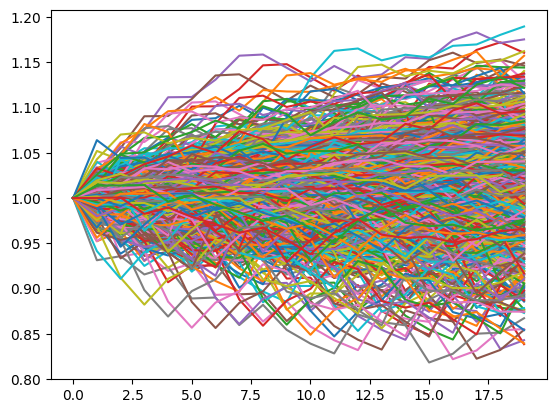

In [54]:

data=[]
train_close=[]
train_index=[]

#計測期間
period=20
for i in range(len(df_train)-(period-1)):
    data.append(df_train[i:i+20])#20日ごとに分割
    train_close.append(data[i]["Close"])
    
    #基準化(最初)
    s=train_close[i][i]
    a=train_close[i]/s

    train_index.append(a.values)
    
    #可視化
    plt.plot(train_index[i])
df_train_index=pd.DataFrame(train_index)
df_train_index

## DTW

In [57]:
distance=[]
path=[]
for i in range(len(train_index)):
    print(len(train_index)-i)
    for j in range(len(train_index)):
        dist,pa=fastdtw(train_index[i], train_index[j])
        distance.append(dist)
        path.append(pa)
#listの分割　
def split_list(l, n):
    """
    リストをサブリストに分割する
    :param l: リスト
    :param n: サブリストの要素数
    :return: 
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]
 
result = list(split_list(distance, len(train_index)))
#DTW行列
c=np.array(result)
#df_c=pd.DataFrame(c)
#df_c.to_csv("train_data.csv",encoding="shift_jis")

934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751
750
749
748
747
746
745
744
743
742
741
740
739
738
737
736
735
734
733
732
731
730
729
728
727
726
725
724
723
722
721
720
719
718
717
716
715
714
713
712
711
710
709
708
707
706
705
704
703
702
701
700
699
698
697
696
695
694
693
692
691
690
689
688
687
686
685


## k-medoids法 (変数：クラスタ数)

In [58]:
from sklearn_extra.cluster import KMedoids
import numpy as np
kmedoid=KMedoids(n_clusters=30, metric='euclidean', method='alternate', init='heuristic', max_iter=300, random_state=None).fit(c)
#cluster追加
df_train_index["cluster"]=kmedoid.labels_
df_train_index.groupby('cluster').count().iloc[:,0]

In [60]:
df_train_index.groupby('cluster').count().iloc[:,0]

cluster
0       6
1      64
2      63
3      48
4      24
5       8
6      13
7       5
8      17
9      22
10      7
11      2
12     33
13     18
14      7
15     51
16     22
17     79
18     14
19     34
20     85
21      6
22     14
23     17
24     12
25     73
26      9
27     56
28    109
29     16
Name: 0, dtype: int64

## 予測手法

In [185]:
#翌月の月末価格の上昇下落ラベル

#月末終値追加
m=[]
for file in all_file:
    data=pd.read_csv(file,header=0)
    m.append(int(data["Close"].tail(1).item()))
df_topix_train["month_close"]=m
#目的変数Upを追加する(翌日の月末が上がる場合1、それ以外は0とする)、'delta_Close'カラムの削除
df_topix_train['Up']=df_topix_train['cluster']
for i in range(len(df_topix_train['month_close'])-1):
    if df_topix_train['month_close'][i] < df_topix_train['month_close'][i+1]:
        df_topix_train['Up'][i]=1
    else:
        df_topix_train['Up'][i]=0
#df = df.drop('delta_Close', axis=1)
#df_test=df_topix_index[["cluster","month_close","Up"]]

<generator object split_list at 0x00000158A688CF90>

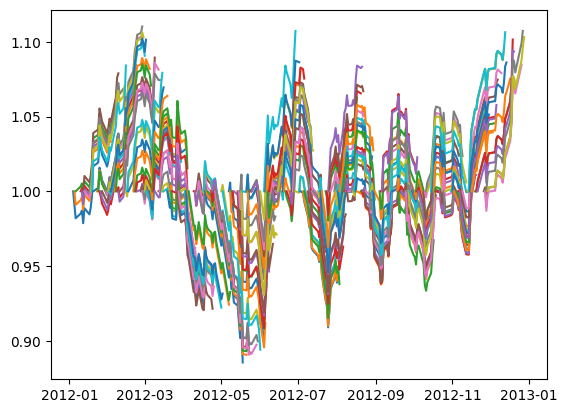

In [88]:
for i in range(len(datas)):
    plt.plot((datas[i]["Close_index"]))

In [83]:
data[1]

1.002591629278614

In [143]:
monthly_data["Adj Close_index"]

Date
1989-01-31    [1.0, 0.9969688245594794, 0.9964635430001699, ...
1989-02-28    [1.0, 1.0046214078099835, 1.0083841148342558, ...
1989-03-31    [1.0, 0.9995498413805264, 0.9984040648144494, ...
1989-04-30    [1.0, 1.0062816616008106, 1.0110232831496961, ...
1989-05-31    [1.0, 1.005672492667638, 1.0164982415301989, 1...
                                    ...                        
2016-08-31    [1.0, 0.9836363181332549, 0.9622871494494447, ...
2016-09-30    [1.0, 1.0025273331966023, 1.0113654691384495, ...
2016-10-31    [1.0, 1.0071314705146874, 1.0128427379665723, ...
2016-11-30    [1.0, 0.9822350138596192, 0.9668746514942769, ...
2016-12-31    [1.0, 0.996433529301582, 0.9890039855326515, 0...
Freq: M, Name: Adj Close_index, Length: 336, dtype: object

In [222]:
train_data=data[:216]
test_data=data[216:]

In [111]:
#DTW計算
distance=[]
path=[]
#dists = np.zeros((len(topix_train), len(topix_train)))
#for i in range(len(topix_train)):
    #for j in range(len(topix_train)):
        #dists[i, j] = fastdtw(topix_train[i], topix_train[j])[0]

for i in range(len(train_data)):
    print(len(train_data)-i)
    for j in range(len(train_data)):
        dist,pa=fastdtw(train_data[i], train_data[j])
        distance.append(dist)
        path.append(pa)

216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [237]:
df_train=pd.DataFrame(train_data)
df_test=pd.DataFrame(test_data)
df_train["Adj Close"]=monthly_data["Adj Close"][:216]
df_test["Adj Close"]=monthly_data["Adj Close"][216:]

In [148]:
#listの分割　
def split_list(l, n):
    """
    #リストをサブリストに分割する
    #:param l: リスト
    #:param n: サブリストの要素数
    #:return: 
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]
 
result = list(split_list(distance, len(train_data)))
#DTW行列
c=np.array(result)
#df_c=pd.DataFrame(c)
#df_c.to_csv("train_data.csv",encoding="shift_jis")
#k-medoids法
from sklearn_extra.cluster import KMedoids


In [238]:
kmedoid=KMedoids(n_clusters=30, metric='euclidean', method='pam', init='heuristic', max_iter=300, random_state=None).fit(c)
#cluster追加
df_train["cluster"]=kmedoid.labels_
df_train.groupby('cluster').count().iloc[:,0]

cluster
0      9
1      6
2      1
3     12
4      6
5      2
6      9
7      2
8      1
9     10
10    11
11     7
12     6
13    13
14     7
15     4
16     3
17     2
18     3
19     1
20    16
21    15
22     5
23     9
24     1
25    14
26    11
27     9
28    13
29     8
Name: Adj Close_index, dtype: int64

In [255]:
#月末価格
df_train["Month_Close"]=df_train["Adj Close"]
for i in range(len(df_train)):
    df_train["Month_Close"][i] = df_train["Adj Close"][i][-1]

#上昇下落ラベル付与
df_train["Up"]=df_train["cluster"]
for i in range(len(df_train)-1):
    if df_train["Month_Close"][i]<df_train["Month_Close"][i+1]:
        df_train["Up"][i]="up"
    else:
        df_train["Up"][i]="down"
#最後は個別で
if df_test["Adj Close"][0][-1]>df_train["Month_Close"][-1]:
    df_train["Up"][-1]="up"
else:
    df_train["Up"][-1]="down"


In [256]:
df_train

,Adj Close_index,Adj Close,cluster,Month_Close,Up
Date,,,,,
1989-01-31,"[1.0, 0.9969688245594794, 0.9964635430001699, ...","[2375.300048828125, 2368.10009765625, 2366.899...",26,2464.800049,down
1989-02-28,"[1.0, 1.0046214078099835, 1.0083841148342558, ...","[2445.10009765625, 2456.39990234375, 2465.6000...",28,2447.199951,up
1989-03-31,"[1.0, 0.9995498413805264, 0.9984040648144494, ...","[2443.800048828125, 2442.699951171875, 2439.89...",21,2469.199951,up
1989-04-30,"[1.0, 1.0062816616008106, 1.0110232831496961, ...","[2467.5, 2483.0, 2494.699951171875, 2469.80004...",29,2488.5,up
1989-05-31,"[1.0, 1.005672492667638, 1.0164982415301989, 1...","[2503.300048828125, 2517.5, 2544.60009765625, ...",28,2537.100098,down
...,...,...,...,...,...
2006-08-31,"[1.0, 1.0016847465121377, 1.0016081706661382, ...","[1567.010009765625, 1569.6500244140625, 1569.5...",26,1634.459961,down
2006-09-30,"[1.0, 1.011020295875991, 1.0057978821714115, 0...","[1633.3499755859375, 1651.3499755859375, 1642....",20,1610.72998,up
2006-10-31,"[1.0, 0.995520312765366, 0.9857672018359822, 1...","[1625.1199951171875, 1617.8399658203125, 1601....",28,1617.420044,down


<h1>検証フェーズ</h1>

In [259]:
df_test

,Adj Close_index,Adj Close
Date,,
2007-01-31,"[1.0, 0.9860972978627798, 0.9959798956702778, ...","[1698.949951171875, 1675.3299560546875, 1692.1..."
2007-02-28,"[1.0, 1.0021972347869716, 0.9871734821972656, ...","[1738.5799560546875, 1742.4000244140625, 1716...."
2007-03-31,"[1.0, 0.9893569833590098, 0.9555200389253412, ...","[1740.1099853515625, 1721.5899658203125, 1662...."
2007-04-30,"[1.0, 1.0129747910426774, 1.0285469925976702, ...","[1682.489990234375, 1704.3199462890625, 1730.5..."
2007-05-31,"[1.0, 1.0064786479864904, 1.0234932994518677, ...","[1693.25, 1704.219970703125, 1733.030029296875..."
...,...,...
2016-08-31,"[1.0, 0.9836363181332549, 0.9622871494494447, ...","[1321.8299560546875, 1300.199951171875, 1271.9..."
2016-09-30,"[1.0, 1.0025273331966023, 1.0113654691384495, ...","[1337.3800048828125, 1340.760009765625, 1352.5..."
2016-10-31,"[1.0, 1.0071314705146874, 1.0128427379665723, ...","[1330.719970703125, 1340.2099609375, 1347.8100..."


In [270]:
test_distance=[]
test_path=[]
#DTW
for i in range(len(test_data)):#テストデータ数分繰り返す 2016-01-01から2020-12-01までの60ヵ月分
    #topix_test.append(test_MinMax_close[i])#学習データに追加
    print(len(test_data)-i)
    for j in range(len(train_data)):#データ数分繰り返す1038
        test_dist,test_pa=fastdtw(test_data[i], train_data[j])
        test_distance.append(test_dist)
        test_path.append(test_pa)
test_result = list(split_list(test_distance,len(train_data)))

120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [282]:
train_data

Date
1989-01-31    [1.0, 0.9969688245594794, 0.9964635430001699, ...
1989-02-28    [1.0, 1.0046214078099835, 1.0083841148342558, ...
1989-03-31    [1.0, 0.9995498413805264, 0.9984040648144494, ...
1989-04-30    [1.0, 1.0062816616008106, 1.0110232831496961, ...
1989-05-31    [1.0, 1.005672492667638, 1.0164982415301989, 1...
                                    ...                        
2006-08-31    [1.0, 1.0016847465121377, 1.0016081706661382, ...
2006-09-30    [1.0, 1.011020295875991, 1.0057978821714115, 0...
2006-10-31    [1.0, 0.995520312765366, 0.9857672018359822, 1...
2006-11-30    [1.0, 0.9978490177481992, 0.9964252616050345, ...
2006-12-31    [1.0, 1.0017695593352298, 0.9962552123657552, ...
Freq: M, Name: Adj Close_index, Length: 216, dtype: object

In [307]:
test_distance=[]
test_path=[]
#DTW
for i in range(len(test_data)):#120
    print(len(test_data)-i)
    for j in range(len(train_data)):#216.217.218...
        test_dist,test_pa=fastdtw(test_data[i], train_data[j])
        test_distance.append(test_dist)
        test_path.append(test_pa)
    # リストの要素を持つDataFrameを作成
    train_df = pd.DataFrame({'data': train_data.values.tolist()}, index=train_data.index)
    train_df
    # 新しいデータを追加
    new_df = pd.DataFrame({'data': test_data.tolist()}, index=test_data.index)
    train_df = pd.concat([train_df, new_df["data"]], axis=1)

    # DataFrameをSeriesに変換
    df_train = pd.Series(train_df['data'].values.tolist(), index=train_df.index)

120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [309]:
df_train

Date
1989-01-31    [[1.0, 0.9969688245594794, 0.9964635430001699,...
1989-02-28    [[1.0, 1.0046214078099835, 1.0083841148342558,...
1989-03-31    [[1.0, 0.9995498413805264, 0.9984040648144494,...
1989-04-30    [[1.0, 1.0062816616008106, 1.0110232831496961,...
1989-05-31    [[1.0, 1.005672492667638, 1.0164982415301989, ...
                                    ...                        
2016-08-31    [nan, [1.0, 0.9836363181332549, 0.962287149449...
2016-09-30    [nan, [1.0, 1.0025273331966023, 1.011365469138...
2016-10-31    [nan, [1.0, 1.0071314705146874, 1.012842737966...
2016-11-30    [nan, [1.0, 0.9822350138596192, 0.966874651494...
2016-12-31    [nan, [1.0, 0.996433529301582, 0.9890039855326...
Freq: M, Length: 336, dtype: object

In [294]:
# リストの要素を持つDataFrameを作成
train_df = pd.DataFrame({'data': train_data.values.tolist()}, index=train_data.index)
train_df
# 新しいデータを追加
new_df = pd.DataFrame({'data': test_data.tolist()}, index=test_data.index)
train_df = pd.concat([train_df, new_df], axis=0)

# DataFrameをSeriesに変換
df_train = pd.Series(train_df['data'].values.tolist(), index=train_df.index)

Date
1989-01-31    [1.0, 0.9969688245594794, 0.9964635430001699, ...
1989-02-28    [1.0, 1.0046214078099835, 1.0083841148342558, ...
1989-03-31    [1.0, 0.9995498413805264, 0.9984040648144494, ...
1989-04-30    [1.0, 1.0062816616008106, 1.0110232831496961, ...
1989-05-31    [1.0, 1.005672492667638, 1.0164982415301989, 1...
                                    ...                        
2016-08-31    [1.0, 0.9836363181332549, 0.9622871494494447, ...
2016-09-30    [1.0, 1.0025273331966023, 1.0113654691384495, ...
2016-10-31    [1.0, 1.0071314705146874, 1.0128427379665723, ...
2016-11-30    [1.0, 0.9822350138596192, 0.9668746514942769, ...
2016-12-31    [1.0, 0.996433529301582, 0.9890039855326515, 0...
Freq: M, Length: 336, dtype: object

In [271]:
test_result = list(split_list(test_distance,len(train_data)))
#DTW行列
test_c=np.array(test_result)
#df_c=pd.DataFrame(c,index=datas,columns=datas)
#df_c.to_csv("dtw.csv",encoding="shift_jis")


#距離に基づき過去の株価変動パターンが近い月を順にn個選ぶ→クラスタリング,勾配降下法,動的計画法
#k-medoids法 
test_kmedoid=KMedoids(n_clusters=30, 
                       metric='euclidean', 
                       method='alternate', 
                       init='heuristic', 
                       max_iter=300, 
                       random_state=None).fit(test_c)
#cluster追加
df_test["cluster"]=test_kmedoid.labels_
#df_test_MinMax_close.groupby('cluster').count().iloc[:,1]

In [272]:
df_test

,Adj Close_index,Adj Close,cluster
Date,,,
2007-01-31,"[1.0, 0.9860972978627798, 0.9959798956702778, ...","[1698.949951171875, 1675.3299560546875, 1692.1...",17
2007-02-28,"[1.0, 1.0021972347869716, 0.9871734821972656, ...","[1738.5799560546875, 1742.4000244140625, 1716....",18
2007-03-31,"[1.0, 0.9893569833590098, 0.9555200389253412, ...","[1740.1099853515625, 1721.5899658203125, 1662....",0
2007-04-30,"[1.0, 1.0129747910426774, 1.0285469925976702, ...","[1682.489990234375, 1704.3199462890625, 1730.5...",28
2007-05-31,"[1.0, 1.0064786479864904, 1.0234932994518677, ...","[1693.25, 1704.219970703125, 1733.030029296875...",23
...,...,...,...
2016-08-31,"[1.0, 0.9836363181332549, 0.9622871494494447, ...","[1321.8299560546875, 1300.199951171875, 1271.9...",0
2016-09-30,"[1.0, 1.0025273331966023, 1.0113654691384495, ...","[1337.3800048828125, 1340.760009765625, 1352.5...",27
2016-10-31,"[1.0, 1.0071314705146874, 1.0128427379665723, ...","[1330.719970703125, 1340.2099609375, 1347.8100...",23


In [273]:
#月末価格
df_test["Month_Close"]=df_test["Adj Close"]
for i in range(len(df_test)):
    df_test["Month_Close"][i] = df_test["Adj Close"][i][-1]

#上昇下落ラベル付与
df_test["Up"]=df_test["cluster"]
for i in range(len(df_test)-1):
    if df_test["Month_Close"][i]<df_test["Month_Close"][i+1]:
        df_test["Up"][i]="up"
    else:
        df_test["Up"][i]="down"
#最後は個別で
if df_test["Adj Close"][0][-1]>df_test["Month_Close"][-1]:
    df_test["Up"][-1]="up"
else:
    df_test["Up"][-1]="down"


In [274]:
df_test

,Adj Close_index,Adj Close,cluster,Month_Close,Up
Date,,,,,
2007-01-31,"[1.0, 0.9860972978627798, 0.9959798956702778, ...","[1698.949951171875, 1675.3299560546875, 1692.1...",17,1721.959961,up
2007-02-28,"[1.0, 1.0021972347869716, 0.9871734821972656, ...","[1738.5799560546875, 1742.4000244140625, 1716....",18,1752.73999,down
2007-03-31,"[1.0, 0.9893569833590098, 0.9555200389253412, ...","[1740.1099853515625, 1721.5899658203125, 1662....",0,1713.609985,down
2007-04-30,"[1.0, 1.0129747910426774, 1.0285469925976702, ...","[1682.489990234375, 1704.3199462890625, 1730.5...",28,1701.0,up
2007-05-31,"[1.0, 1.0064786479864904, 1.0234932994518677, ...","[1693.25, 1704.219970703125, 1733.030029296875...",23,1755.680054,up
...,...,...,...,...,...
2016-08-31,"[1.0, 0.9836363181332549, 0.9622871494494447, ...","[1321.8299560546875, 1300.199951171875, 1271.9...",0,1329.540039,down
2016-09-30,"[1.0, 1.0025273331966023, 1.0113654691384495, ...","[1337.3800048828125, 1340.760009765625, 1352.5...",27,1322.780029,up
2016-10-31,"[1.0, 1.0071314705146874, 1.0128427379665723, ...","[1330.719970703125, 1340.2099609375, 1347.8100...",23,1393.02002,up


In [175]:

df_test["Pred_Up"]=df_test["Up"]
touti=1

#正解ラベルの付与
    for j in range(30):#クラスタ数回
        if df_test_MinMax_close["cluster"][i]==j:#クラスタ数の特定
        #クラスタ内の上昇（下落）ラベルの多数決
            n=df_topix_tests[df_topix_tests["cluster"]==j]
            n.reset_index(inplace=True)
            n["Time"] = pd.to_datetime(n["index"])
            up=int((n['Up']=="up").sum())#上昇ラベルの総数
            down=int((n["Up"]=="down").sum())#下落ラベルの総数
    if up-down>=touti:#上昇ラベルの方が多い場合
        #df_test_MinMax_close["pred_Up"]=df_test_MinMax_close["cluster"]
        df_test_MinMax_close["pred_Up"][i]="up"
        position=df_test_MinMax_close["month_close"][i]#月末価格で購入
        #m_date=(n["Time"][j]+relativedelta(months=+1)).strftime('%Y-%m-%d')
        #m_date=pd.to_datetime(m_date)
        #df_test_MinMax_close.reset_index(inplace=True)
        #df_test_MinMax_close["Time"] = pd.to_datetime(df_test_MinMax_close.index)
        #n.set_index("index", inplace = True)
        #df_test_MinMax_close["Time"][0]+relativedelta(months=+1)
        #df_train["month_close"][df_train["Time"] [0] +relativedelta(months=+1).fromtimestamp(ts)]
        rikaku=df_test_MinMax_close["month_close"][i+1]#翌月価格
        profit=rikaku-position#翌月価格で売った時の収益
        month_return=(rikaku/position)#リターン％
        return_graph.append(month_return)
        ruiseki_return=(ruiseki_return+month_return)#累積収益率
        print(ruiseki_return)
        #sum=sum+profit#利益の合計
        #print("利益=",sum)
    #s.append(sum)#毎月の利益
    elif up-down>=touti:
        #df_test_MinMax_close["pred_Up"]=df_test_MinMax_close["cluster"]
        df_test_MinMax_close["pred_Up"][i]="down"
        position=df_test_MinMax_close["month_close"][i]#月末価格で売却
        #df_test_MinMax_close["Time"] = pd.to_datetime(df_test_MinMax_close.index
        rikaku=df_test_MinMax_close["month_close"][i+1]#翌月価格
        profit=position-rikaku#翌月価格で買った時の収益
        month_return=(rikaku/position)#リターン％
        return_graph.append(month_return)
        ruiseki_return=(ruiseki_return+month_return)#累積収益率
        print(ruiseki_return)
    #ruiseki_return=(1+month_return).cumprod()#累積収益率
    #sum=sum+profit#利益の合計
    #print("利益=",sum)
#s.append(sum)

#結果
acc=0
bunbo=0
for i in range(60):
    if df_test_MinMax_close["pred_Up"][i]=="up" or df_test_MinMax_close["pred_Up"][i]=="down":
        bunbo=bunbo+1
        if df_test_MinMax_close["pred_Up"][i]==df_test_MinMax_close["Up"][i]:
            acc=acc+1
print("累積収益率：",100+ruiseki_return,"%")
print("正解率：",(acc/bunbo)*100,"%")

0.9057262569832403
1.9442767581397553
2.939080024657944
3.9681845022698843
5.030031891828117
6.035326899392414
7.030059781258479
8.083766286553487
9.1383247933733
10.171680817879768
11.173657102464748
12.1586733891097
13.171239526675837
14.195406737649057
15.23065720147095
16.285018013896277
17.300315464321205
18.3107722612392
19.29388987519531
20.30718467288317
21.29691656107484
22.20280538881287
23.215563590513963
24.111784346362793
25.160646461489968
26.186172945216835
27.17621650464434
28.192558427963007
29.127623363027944
30.153417013821596
31.162443448379946
32.127938656047675
33.17823647206356
34.228646049883345
35.24784221065119
36.176981283498876
37.24460423431855
38.24140525799098
39.24573158679196
40.27423785817167
累積収益率： 140.27423785817166 %
正解率： 67.5 %


In [174]:
bunbo

7

In [172]:
acc=0
bunbo=0
for i in range(60):
    if df_test_MinMax_close["pred_Up"][i]=="up" or df_test_MinMax_close["pred_Up"][i]=="down":
        bunbo=bunbo+1
        if df_test_MinMax_close["pred_Up"][i]==df_test_MinMax_close["Up"][i]:
            acc=acc+1
print("累積収益率：",100+ruiseki_return,"%")
print("正解率：",(acc/bunbo)*100,"%")

累積収益率： 106.88579980468658 %
正解率： 42.857142857142854 %


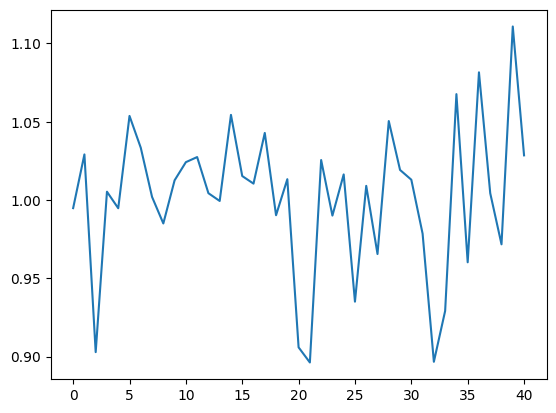

In [105]:
plt.plot(return_graph)

In [ ]:
#変動率
#テクニカル指標
#月、週、日単位の平均、標準偏差
#移動平均線のパターン分析
#トレンド・季節性・周期性・不規則性→不規則性を削除もしくは不規則性のトレンドのみに適用

In [ ]:
# 終値の前日比の追加
df_shift = df.shift(1)

df['Close_ratio'] = (df['Close'] - df_shift['Close']) / df_shift['Close']
df

# 始値と終値の差分を追加
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
1965-01-05,0,1,1.163391e+05,1.163391e+05,1.163391e+05,1.163391e+05,1,NaN
1965-01-06,0,2,1.169191e+05,1.169191e+05,1.169191e+05,1.169191e+05,1,0.004985
1965-01-07,0,3,1.178700e+05,1.178700e+05,1.178700e+05,1.178700e+05,1,0.008133
1965-01-08,0,4,1.189948e+05,1.189948e+05,1.189948e+05,1.189948e+05,1,0.009543
1965-01-12,1,1,1.191900e+05,1.191900e+05,1.191900e+05,1.191900e+05,0,0.001640
...,...,...,...,...,...,...,...,...
2021-10-15,2962,4,2.690117e+06,2.657175e+06,2.662822e+06,2.688848e+06,0,0.018133
2021-10-18,2963,0,2.695851e+06,2.675507e+06,2.691178e+06,2.684855e+06,1,-0.001485
2021-10-19,2963,1,2.707705e+06,2.689472e+06,2.693348e+06,2.702436e+06,1,0.006548


## 検証データによる予測と精度検証

In [ ]:
#参考文献
k-medoids
#https://python-kmedoids.readthedocs.io/en/latest/